# trying to steer using transformerlens 

april 26 

In [1]:
from transformer_lens import HookedTransformer
import transformer_lens
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import transformer_lens.utils as utils
import hashlib
import yaml 
import hashlib
import pickle
import numpy as np
import matplotlib.pyplot as plt 

/root/mech_interp_research/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_grad_enabled(False)

In [3]:
device = utils.get_device()

reference_model_path = 'meta-llama/Llama-3.1-8B'
baseline_model_path = "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"

baseline_model_hf = AutoModelForCausalLM.from_pretrained(baseline_model_path, torch_dtype=torch.bfloat16)
baseline_model_tokenizer = AutoTokenizer.from_pretrained(baseline_model_path)

model = HookedTransformer.from_pretrained_no_processing(
    reference_model_path,
    hf_model=baseline_model_hf,
    tokenizer=baseline_model_tokenizer,
    device=device,
    move_to_device=True,
)


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer


In [4]:
weight_vectors = np.load('layer_analyses/combined_delta_vectors.npy')

In [5]:
def produce_layer_resid_pre_steering_hook(steering_vector, scale=1.0):
    def resid_pre_hook(
        value,
        hook
    ):
        value[:, -1, :] += steering_vector.to(value)*scale
        return value

    return resid_pre_hook

In [6]:
def set_steering_vectors(
    model,
    target_layer_indices,
    weight_vectors,
    scale=1.0,
):
    """ 
    Adds steering vectors to the model at the specified layer indices.
    add only to resid_pre 

    Args:
        model (HookedTransformer): The model to modify.
        target_layer_indices (list of int): The layer indices to add steering vectors to.
        weight_vectors (np.ndarray): The steering vectors to add.
        scale (float): The scaling factor for the steering vectors.
    """
    model.reset_hooks()
    for block_idx, block in enumerate(model.blocks):
        if block_idx in target_layer_indices:
            # Get the steering vector for this block
            steering_vector = weight_vectors[block_idx]
            # Create the hook function
            resid_pre_hook = produce_layer_resid_pre_steering_hook(steering_vector, scale)
            # Add the hook to the model
            model.add_hook(
                utils.get_act_name('resid_pre', block_idx),
                resid_pre_hook
            )


In [44]:
steering_vectors = [None]+[-torch.tensor(w[None, :], device='cuda:0') for w in weight_vectors]

In [45]:
steering_vectors[3].shape

torch.Size([1, 4096])

In [78]:
set_steering_vectors(
    model,
    target_layer_indices=range(10, 25),
    weight_vectors=steering_vectors,
    scale=1,
)

In [79]:
chat = [
  {"role": "user", "content": "What's the fifth prime?"},
]

prompt = model.tokenizer.apply_chat_template(chat, add_generation_prompt=True, tokenize=False)


In [80]:
test_output = model.generate(
    prompt,
    max_new_tokens=256,
    do_sample=False,
)

  0%|          | 0/256 [00:00<?, ?it/s]

  5%|▍         | 12/256 [00:00<00:19, 12.32it/s]


In [81]:
print(test_output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
**Solution:**
The fifth prime number is 7.


# Experiments 

**initial model**
there exist heads which toggle thinking early on 

these signals 



1) which layer is most important? 

2) try steering with the OV circuit of head (0, 22) applied to <think> 

In [13]:
model.W_O.shape

torch.Size([32, 32, 128, 4096])

In [14]:
target_o = model.W_O[0, 22]

In [22]:
think_steering_vector = model.W_E[128013]@model.W_V[0, 22]@model.W_O[0, 22]

think_steering_vector /= torch.linalg.norm(think_steering_vector)

stopthink_steering_vector = model.W_E[128014]@model.W_V[0, 22]@model.W_O[0, 22]

stopthink_steering_vector /= torch.linalg.norm(stopthink_steering_vector)

In [23]:
think_steering_vectors = [None]*32 

think_steering_vectors = [think_steering_vector.reshape((1, 4096)) for _ in range(32)]

In [24]:
think_steering_vectors = [None]*32 

stopthink_steering_vectors = [stopthink_steering_vector.reshape((1, 4096)) for _ in range(32)]

In [28]:
set_steering_vectors(
    model,
    target_layer_indices=[0],
    weight_vectors=stopthink_steering_vectors,
    scale=.5,
)

In [29]:
test_output = model.generate(
    prompt,
    max_new_tokens=256,
    do_sample=False,
)

  0%|          | 0/256 [00:00<?, ?it/s]

100%|██████████| 256/256 [00:18<00:00, 13.70it/s]


In [30]:
print(test_output)

<｜User｜>What's the fifth prime?<｜Assistant｜><think>
To determine the fifth prime number, I'll start by listing the prime numbers in order.

First, I'll identify the first prime, which is 2. Next, I'll move to the second prime, which is 3. Then, I'll list the third prime, 5, and the fourth prime, 7. After that, the fifth prime is 11.
</think>

To find the fifth prime, I'll begin listing the prime numbers in sequence. Starting fromThe first prime is 2, followed the Second prime is 3, the Third prime is 5, and the Fourth prime is 7. Continuing this sequence, the Fifth prime is 11.
</think>

</think>

</think>

</think>

</think>

To determine the fifth prime number, I'll follow the sequence of prime numbers. Starting from the first prime, which is 2, I'll move to the second prime, 3. Then, I'll identify the third prime, 5, and finally reach the fifth prime, 11. This systematic approach ensures that I systematically list out the prime numbers in their natural order.

By following this meth

Q: can we use one of the lda directions to steer think vs nonthink  

lda is think vs nonthink in later layers 

and less significant components control turning this on early on 
---------
how does stop think get triggered?

difference in mean vector vs lda direction 



# ideas 

 - when we injected ov(0, 22).think at layer 0, the network thought, tried to end thinking, and did so repeatedly  

what if we look at the logit of <\think> after adding in different ov.think vectors from different heads 

which one contributed something that's most like "think"

- by what mechanism does the model try to activate <\think>? 

once its finished thinking, it tries to stop 

what do the 

In [33]:
normed_think = model.W_E[128013] / torch.linalg.norm(model.W_E[128013])
normed_stopthink = model.W_E[128014] / torch.linalg.norm(model.W_E[128014])

In [38]:
normed_stopthink@normed_think

tensor(0.1200, device='cuda:0')

What happens if i look at how aligned or antialigned think and stop-think vectors are at each layer 

In [41]:
def compute_thinking_alignment(layer_idx, head_idx):
    """
    Computes the alignment between the thinking and stopthinking vectors for a given layer and head.

    Args:
        layer_idx (int): The index of the layer.
        head_idx (int): The index of the head.

    Returns:
        float: The alignment score.
    """
    # Get the steering vectors for the specified layer and head
    think_vector = model.W_E[128013] @ model.W_V[layer_idx, head_idx] @ model.W_O[layer_idx, head_idx]
    stopthink_vector = model.W_E[128014] @ model.W_V[layer_idx, head_idx] @ model.W_O[layer_idx, head_idx]

    # Normalize the vectors
    normed_think = think_vector / torch.linalg.norm(think_vector)
    normed_stopthink = stopthink_vector / torch.linalg.norm(stopthink_vector)

    # Compute the alignment score
    alignment_score = normed_stopthink @ normed_think

    return alignment_score.item()

In [42]:
""" 
plot the alignment scores for each layer and head 
use a heatmap to visualize the scores
"""
def plot_alignment_scores():
    """
    Plots the alignment scores for each layer and head as a heatmap.

    Returns:
        None
    """
    # Initialize an array to store the alignment scores
    alignment_scores = np.zeros((model.cfg.n_layers, model.cfg.n_heads))

    # Compute the alignment scores for each layer and head
    for layer_idx in range(model.cfg.n_layers):
        for head_idx in range(model.cfg.n_heads):
            alignment_scores[layer_idx, head_idx] = compute_thinking_alignment(layer_idx, head_idx)

    # Plot the alignment scores as a heatmap
    plt.imshow(alignment_scores, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Alignment Score')
    plt.xlabel('Head Index')
    plt.ylabel('Layer Index')
    plt.title('Thinking vs Stopthinking Alignment Scores')
    plt.show()
    

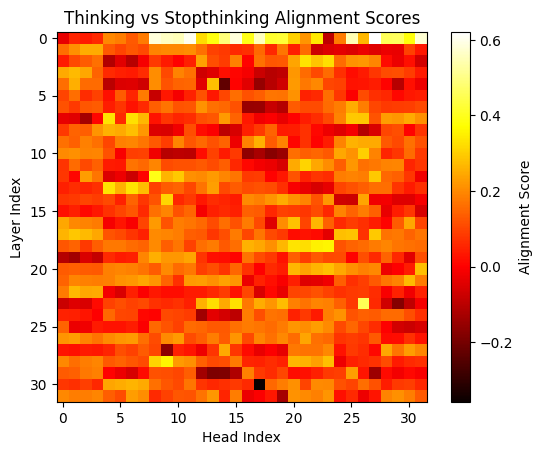

In [43]:
plot_alignment_scores()

In [37]:
model.W_E[128013]@model.W_V[0, 22]@model.W_O[0, 22]

tensor([ 8.0637e-05,  8.1090e-06, -2.1838e-04,  ...,  1.6519e-04,
        -8.9628e-05, -1.8325e-04], device='cuda:0')

In [36]:
1/np.sqrt(4096)

np.float64(0.015625)

In [20]:
<\think>

SyntaxError: invalid syntax (3778656465.py, line 1)

In [ ]:
model.W_U

In [21]:
model.to_tokens("</think>")

tensor([[128000, 128014]], device='cuda:0')